In [1]:
# Step 1: Setup Google Colab Environment

!pip install lifelines pandas matplotlib seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c5f6c26794ddc5e4abf5c3f24db76a6f96630e0df041c17059f008e7c6e48070
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
# Step 2: Upload dan Load Dataset

from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_csv('startup_data.csv')
df.head()

Saving startup_data.csv to startup_data (1).csv


,startup_name,founded_year,end_year,status,sector,location,funding_amount,founder_background,num_employees
0,Startup_1,2014,2019.0,bangkrut,SaaS,Jakarta,2331785,non-tech,235
1,Startup_2,2011,2014.0,pivot,Logistics,Medan,3953339,non-tech,194
2,Startup_3,2013,NaN,aktif,E-commerce,Bandung,9567719,tech,229
3,Startup_4,2016,2019.0,bangkrut,E-commerce,Yogyakarta,1096107,non-tech,287
4,Startup_5,2017,NaN,aktif,Fintech,Jakarta,7230144,tech,125


In [3]:
# Step 3: Preprocessing untuk Analisis Survival

import numpy as np

# Tahun saat ini sebagai patokan
current_year = 2025

# Buat kolom durasi hidup startup
df['duration'] = np.where(df['end_year'].isna(), current_year - df['founded_year'], df['end_year'] - df['founded_year'])

# Buat kolom event: 1 jika startup mengalami event (bangkrut atau pivot), 0 jika masih aktif
df['event_observed'] = np.where(df['status'] == 'aktif', 0, 1)

df[['startup_name', 'founded_year', 'end_year', 'status', 'duration', 'event_observed']].head()

,startup_name,founded_year,end_year,status,duration,event_observed
0,Startup_1,2014,2019.0,bangkrut,5.0,1
1,Startup_2,2011,2014.0,pivot,3.0,1
2,Startup_3,2013,NaN,aktif,12.0,0
3,Startup_4,2016,2019.0,bangkrut,3.0,1
4,Startup_5,2017,NaN,aktif,8.0,0


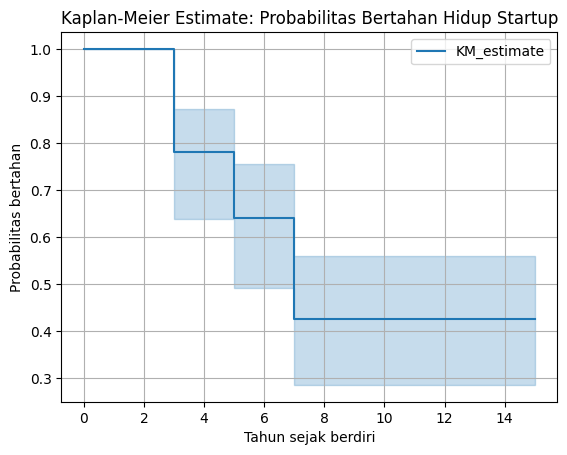

In [4]:
# Step 4: Analisis Kaplan-Meier

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

kmf.fit(durations=df['duration'], event_observed=df['event_observed'])

kmf.plot_survival_function()
plt.title('Kaplan-Meier Estimate: Probabilitas Bertahan Hidup Startup')
plt.xlabel('Tahun sejak berdiri')
plt.ylabel('Probabilitas bertahan')
plt.grid(True)
plt.show()

Gambar ini menunjukkan estimasi Kaplan-Meier untuk semua startup secara umum, dengan probabilitas bertahan turun drastis dalam 5–7 tahun pertama.

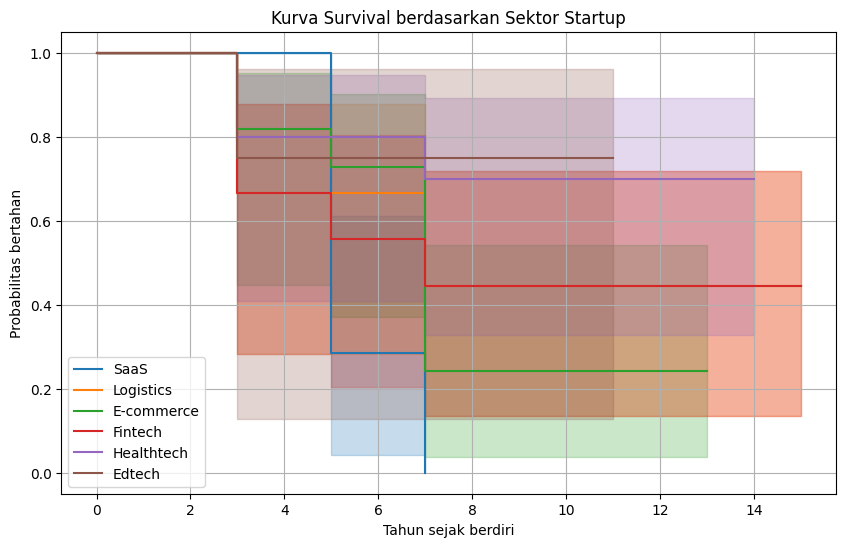

In [5]:
# Step 5: Survival Berdasarkan Kategori

plt.figure(figsize=(10, 6))

for sector in df['sector'].unique():
    sector_df = df[df['sector'] == sector]
    kmf.fit(durations=sector_df['duration'], event_observed=sector_df['event_observed'], label=sector)
    kmf.plot_survival_function()

plt.title('Kurva Survival berdasarkan Sektor Startup')
plt.xlabel('Tahun sejak berdiri')
plt.ylabel('Probabilitas bertahan')
plt.legend()
plt.grid(True)
plt.show()

Gambar ini membandingkan survival curve berdasarkan sektor; terlihat perbedaan probabilitas bertahan yang cukup signifikan antar sektor, terutama antara Healthtech dan SaaS.

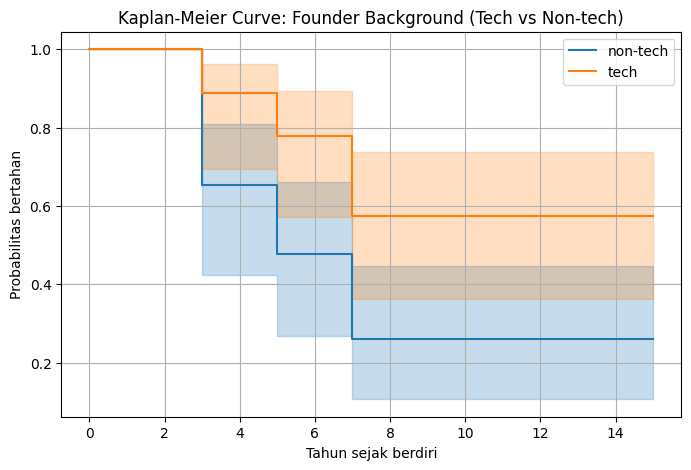

In [6]:
# Step 6: Survival berdasarkan Latar Belakang Founder

plt.figure(figsize=(8, 5))

for group in df['founder_background'].unique():
    sub_df = df[df['founder_background'] == group]
    kmf.fit(durations=sub_df['duration'], event_observed=sub_df['event_observed'], label=group)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve: Founder Background (Tech vs Non-tech)')
plt.xlabel('Tahun sejak berdiri')
plt.ylabel('Probabilitas bertahan')
plt.legend()
plt.grid(True)
plt.show()

Gambar ini adalah hasil Cox Regression, menunjukkan bahwa latar belakang founder (tech vs non-tech) memiliki pengaruh negatif signifikan terhadap risiko bangkrut/pivot (log(HR) < 0).

In [7]:
# Step 7: Siapkan Variabel untuk Cox Regression

from sklearn.preprocessing import LabelEncoder

# Encode sektor dan latar belakang founder
df['sector_encoded'] = LabelEncoder().fit_transform(df['sector'])
df['founder_encoded'] = LabelEncoder().fit_transform(df['founder_background'])

In [8]:
# Step 8: Fit Cox Model

from lifelines import CoxPHFitter

# Pilih fitur relevan
cox_data = df[['duration', 'event_observed', 'funding_amount', 'num_employees', 'sector_encoded', 'founder_encoded']]

# Fit model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='duration', event_col='event_observed')

# Lihat hasilnya
cph.print_summary()

#    coef > 0 → faktor ini meningkatkan risiko bangkrut/pivot (memperpendek survival).
#    coef < 0 → faktor ini menurunkan risiko bangkrut/pivot (memperpanjang survival).
#    p-value < 0.05 → faktor ini secara statistik signifikan.

<lifelines.CoxPHFitter: fitted with 50 total observations, 22 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 28
   partial log-likelihood = -95.93
         time fit was run = 2025-04-16 02:41:29 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
funding_amount  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_employees    0.00      1.00      0.00           -0.01            0.01                0.99                1.01
sector_encoded   0.07      1.08      0.12           -0.16            0.31                0.85                1.36
founder_encoded -0.85      0.43      0.40           -1.64           -0.07                0.19                0.94

                 cmp to     z    p  -log2(p)
covariate                                   
funding_amount     0.00 -0.62 0.54      0.90
num_employees      0.00  0.16 0.87      0.20
sector_encoded     0.00  0.61 0.54      0.89
founder_encoded    0.00 -2.12 0.03      4.89
---
Concordance = 0.65
Partial AIC = 199.85
log-likelihood ratio test = 6.63 on 4 df
-log2(p) of ll-ratio test = 2.67

Informasi Umum Model:

-    Observasi total: 50 startup

-    Event observed: 28 (startup yang mengalami pivot atau bangkrut)

-    Partial Log-likelihood: -95.93 → semakin tinggi (kurang negatif), semakin baik

-    Partial AIC: 199.85 → semakin rendah, semakin baik

Hasil Estimasi Koefisien:
- funding_amount	-0.00	1.00	❌ (p=0.54)	Tidak ada pengaruh signifikan; efek pendanaan terhadap risiko sangat kecil dan tidak pasti.
- num_employees	+0.00	1.00	❌ (p=0.87)	Tidak signifikan; jumlah karyawan tidak terbukti mengubah risiko secara bermakna.
- sector_encoded	+0.07	1.08	❌ (p=0.54)	Tidak signifikan; variasi sektor tidak terlalu memengaruhi peluang bertahan hidup startup.
- founder_encoded	-0.85	0.43	✅ (p=0.03)	Signifikan secara statistik. Startup dengan founder tech (asumsinya encoded sebagai 0) memiliki risiko pivot/bangkrut lebih rendah dibanding non-tech.

- Interpretasi exp(coef) untuk founder: Startup dengan founder tech punya 57% lebih kecil risiko bangkrut/pivot dibanding non-tech founders (1 - 0.43 = 0.57).

Model Evaluation Metrics:

-    Concordance index: 0.65 → Cukup bagus, artinya model bisa membedakan mana startup yang lebih berisiko dengan akurasi 65% (skala 0.5–1).

-    Log-likelihood ratio test: 6.63 dengan p-value cukup kecil (–log2(p) = 2.67 → p ≈ 0.15) → tidak sangat signifikan, tapi menunjukkan bahwa model punya some predictive power.

Kesimpulan Strategis:

-    Model ini hanya memiliki 1 variabel signifikan: latar belakang founder (tech vs non-tech).

-    Variabel seperti pendanaan dan jumlah karyawan belum terbukti signifikan dalam model ini — bisa jadi karena: (1) Ukuran sampel kecil (hanya 50 startup), atau (2) Variabel kurang variatif atau distribusinya tidak tepat.

-    Concordance 0.65 menunjukkan model bisa dipakai, tapi masih bisa ditingkatkan (misalnya tambahkan: revenue, growth rate, investor type, dll.)

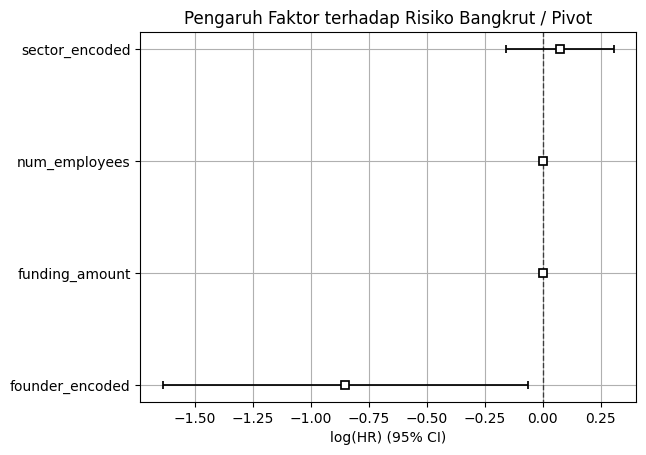

In [9]:
# Step 9: Visualisasi Pengaruh Faktor

cph.plot()
plt.title("Pengaruh Faktor terhadap Risiko Bangkrut / Pivot")
plt.grid(True)
plt.show()

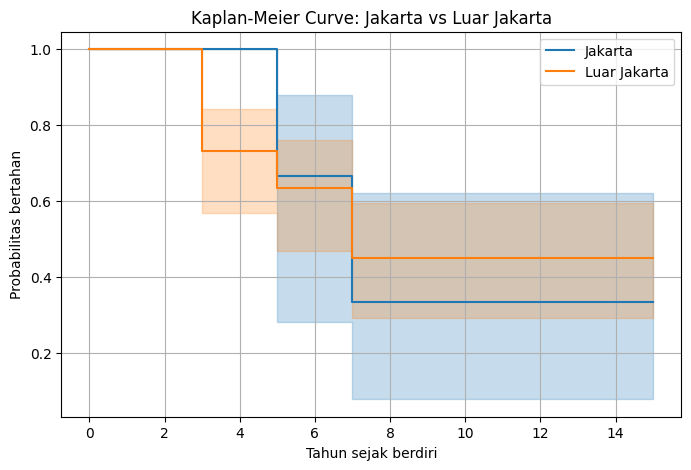

In [10]:
# Step 10: Kaplan-Meier berdasarkan Lokasi

df['jakarta_vs_other'] = df['location'].apply(lambda x: 'Jakarta' if x == 'Jakarta' else 'Luar Jakarta')

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))

for lokasi in df['jakarta_vs_other'].unique():
    subset = df[df['jakarta_vs_other'] == lokasi]
    kmf.fit(durations=subset['duration'], event_observed=subset['event_observed'], label=lokasi)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curve: Jakarta vs Luar Jakarta")
plt.xlabel("Tahun sejak berdiri")
plt.ylabel("Probabilitas bertahan")
plt.legend()
plt.grid(True)
plt.show()

Gambar ini memperlihatkan kurva survival Jakarta vs luar Jakarta; startup Jakarta tampak sedikit lebih bertahan, meskipun perbedaannya tidak terlalu drastis.

In [11]:
# Step 10a: (Opsional): Uji Signifikansi (Log-Rank Test)
# Untuk melihat apakah perbedaan survival Jakarta vs Luar Jakarta signifikan secara statistik.

from lifelines.statistics import logrank_test

group_jakarta = df[df['jakarta_vs_other'] == 'Jakarta']
group_luarjakarta = df[df['jakarta_vs_other'] == 'Luar Jakarta']

results = logrank_test(
    group_jakarta['duration'], group_luarjakarta['duration'],
    event_observed_A=group_jakarta['event_observed'],
    event_observed_B=group_luarjakarta['event_observed']
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.05 0.83      0.27



Tidak ada perbedaan signifikan antara dua grup yang dibandingkan dalam hal probabilitas bertahan hidup (survival probability) karena p = 0.83 ≫ 0.05, maka kita gagal menolak hipotesis nol.

Dengan kata lain, berdasarkan data ini, kita tidak bisa menyimpulkan bahwa survival startup di kedua grup tersebut berbeda secara statistik.

<lifelines.WeibullAFTFitter: fitted with 50 total observations, 22 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
   number of observations = 50
number of events observed = 28
           log-likelihood = -97.20
         time fit was run = 2025-04-16 02:47:25 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                       
lambda_ funding_amount  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        num_employees   0.00      1.00      0.00           -0.00            0.01                1.00                1.01
        Intercept       1.91      6.72      0.45            1.02            2.79                2.78               16.25
rho_    Intercept       0.40      1.49      0.16            0.08            0.72                1.09                2.05

                        cmp to    z      p  -log2(p)
param   covariate                                   
lambda_ funding_amount    0.00 1.32   0.19      2.42
        num_employees     0.00 0.72   0.47      1.08
        Intercept         0.00 4.23 <0.005     15.39
rho_    Intercept         0.00 2.48   0.01      6.23
---
Concordance = 0.55
AIC = 202.40
log-likelihood ratio test = 2.09 on 2 df
-log2(p) of ll-ratio test = 1.51

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 50 total observations, 22 right-censored observations>
   number of observations = 50
number of events observed = 28
           log-likelihood = -100.50
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 13.32      2.52            8.39           18.26

         cmp to    z      p  -log2(p)
lambda_    0.00 5.29 <0.005     22.97
---
AIC = 203.00

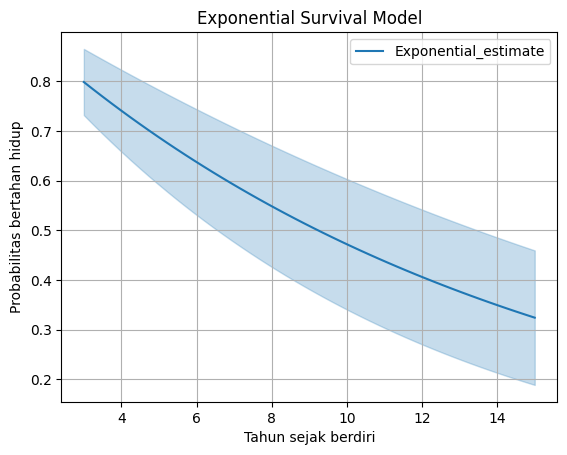

In [12]:
# Step 11: Parametric Survival Models:
# - Exponential: asumsikan risiko konstan dari waktu ke waktu
# - Weibull: fleksibel, bisa modelkan risiko yang naik atau turun seiring waktu

from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()

aft.fit(df[['duration', 'event_observed', 'funding_amount', 'num_employees']],
        duration_col='duration', event_col='event_observed')

aft.print_summary()

# Koefisien (coef) negatif → memperpanjang umur startup.
# p < 0.05 → faktor signifikan secara statistik
# Model ini menghasilkan Median Survival Time untuk setiap kombinasi fitur

from lifelines import ExponentialFitter

expf = ExponentialFitter()
expf.fit(df['duration'], event_observed=df['event_observed'])

expf.print_summary()

# Plot Survival Curve
expf.plot_survival_function()
plt.title("Exponential Survival Model")
plt.xlabel("Tahun sejak berdiri")
plt.ylabel("Probabilitas bertahan hidup")
plt.grid(True)
plt.show()

# Weibull digunakan saat ingin memprediksi risiko di tahun ke-10 atau ke-15 atau saat ingin mengukur efek kuantitatif dari pendanaan, lokasi, dll.

Interpretasi:

- funding_amount:	0.00	1.00	0.19	❌ ->	Pendanaan tidak memengaruhi hazard rate secara signifikan
- num_employees:	0.00	1.00–1.01	0.47	❌ ->	Jumlah karyawan juga tidak punya pengaruh signifikan
- Intercept	1.91	6.72 <0.005	✅ Ya ->	Nilai dasar hazard rate (baseline hazard) cukup tinggi
- rho_ (Intercept)	0.40	1.49	0.01	✅ Ya ->	Param distribusi eksponensialnya signifikan → menunjukkan model tidak sepenuhnya konstan

-    Secara keseluruhan, variabel utama (funding & karyawan) tidak signifikan secara statistik dalam model ini.

Indikator tes:

-     Nilai = 2.09, df = 2

-    p-value tinggi → gagal tolak H₀
    → Model dengan prediktor funding dan employee tidak jauh lebih baik dari model tanpa prediktor sama sekali (hanya intercept).

-    AIC: 203.00 → lebih tinggi dari model Weibull (200.49), berarti lebih buruk.

-    C-index: 0.55 → nyaris acak; model tidak bagus dalam membedakan risiko antar startup.

Catatan:


-    Model exponential tidak cukup baik untuk data kamu.

-    Pendanaan dan jumlah karyawan tidak signifikan memengaruhi probabilitas survival.

-    Weibull tetap lebih unggul dari sisi fit (AIC lebih rendah, likelihood lebih tinggi).

-    Untuk prediksi dan analisis strategis, hindari eksponensial, kecuali ingin baseline cepat.

Gambar ini adalah model survival eksponensial, dengan penurunan survival yang halus dan konsisten, mencerminkan asumsi hazard rate konstan dari waktu ke waktu.

<lifelines.WeibullAFTFitter: fitted with 50 total observations, 22 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
   number of observations = 50
number of events observed = 28
           log-likelihood = -97.20
         time fit was run = 2025-04-16 02:49:45 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                       
lambda_ funding_amount  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        num_employees   0.00      1.00      0.00           -0.00            0.01                1.00                1.01
        Intercept       1.91      6.72      0.45            1.02            2.79                2.78               16.25
rho_    Intercept       0.40      1.49      0.16            0.08            0.72                1.09                2.05

                        cmp to    z      p  -log2(p)
param   covariate                                   
lambda_ funding_amount    0.00 1.32   0.19      2.42
        num_employees     0.00 0.72   0.47      1.08
        Intercept         0.00 4.23 <0.005     15.39
rho_    Intercept         0.00 2.48   0.01      6.23
---
Concordance = 0.55
AIC = 202.40
log-likelihood ratio test = 2.09 on 2 df
-log2(p) of ll-ratio test = 1.51

Prediksi umur median startup: 6.54 tahun


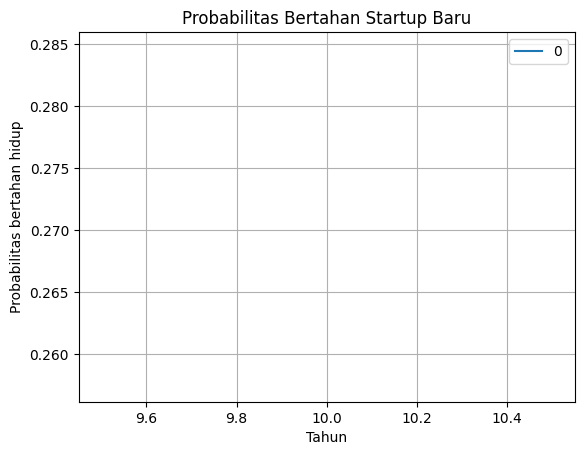

In [13]:
# Step 12: Simulasi dan prediksi umur startup

from lifelines import WeibullAFTFitter

# Pilih fitur prediktor yang relevan
features = ['funding_amount', 'num_employees']

aft = WeibullAFTFitter()
aft.fit(df[['duration', 'event_observed'] + features], duration_col='duration', event_col='event_observed')

aft.print_summary()

import pandas as pd

# Misal kita buat startup baru dengan funding USD3 juta dan 25 karyawan

# Simulasi data startup baru
new_startup = pd.DataFrame([{
    'funding_amount': 3000000,
    'num_employees': 25
}])

# Prediksi berapa tahun kemungkinan bertahan (median survival time)
predicted_median = aft.predict_median(new_startup)

print(f"Prediksi umur median startup: {predicted_median.values[0]:.2f} tahun")

# Probabilitas bertahan hingga tahun ke-10
aft.predict_survival_function(new_startup, times=[10]).plot()
plt.title("Probabilitas Bertahan Startup Baru")
plt.xlabel("Tahun")
plt.ylabel("Probabilitas bertahan hidup")
plt.grid(True)
plt.show()

Interpretasi:

- Log-likelihood: -97.20 (lebih baik dari exponential dan Cox)

- AIC: 202.40 (lebih rendah dari exponential, sedikit lebih tinggi dari Weibull semi-parametrik)

- Concordance index: 0.55 → menunjukkan kemampuan diskriminasi rendah (dekat dengan acak)

- funding_amount	0.00	1.00	❌ (p=0.19)	-> Tidak signifikan — jumlah pendanaan tidak memengaruhi durasi hidup secara bermakna
- num_employees	0.00	1.00–1.01	❌ (p=0.47)	-> Tidak signifikan — ukuran tim juga tidak punya efek besar
- Intercept	1.91	6.72	✅ (<0.005)	-> Baseline survival time signifikan dan cukup tinggi
- rho_ (shape)	0.40	1.49	✅ (p=0.01)	-> Distribusi survival tidak eksponensial; hazard meningkat seiring waktu (positive aging)

Dengan kata lain, risiko bangkrut atau pivot bertambah seiring waktu, bukan konstan.

- 6.54 tahun → ini adalah prediksi median survival time berdasarkan model Weibull untuk startup baru dengan karakteristik tertentu.

- Artinya: 50% startup diprediksi bertahan lebih dari 6.5 tahun, 50% sisanya kemungkinan sudah pivot atau bangkrut sebelum itu.

AIC 202.40 sedikit lebih buruk dari model Weibull semi-parametrik (AIC 200.49), tapi masih lebih baik dari Exponential (AIC 203.00).

Concordance 0.55 menunjukkan model masih lemah dalam membedakan mana startup yang berisiko tinggi vs rendah — kemungkinan karena variabel masih terbatas atau data terlalu kecil.



Weibull AFT cocok untuk estimasi waktu survival dan prediksi median umur startup. Namun, variabel input (funding, employee) belum cukup menjelaskan variabilitas survival.

 Tetap gunakan Weibull jika ingin prediksi survival individual, tapi untuk klasifikasi risiko tinggi vs rendah, kamu perlu menambah variabel baru (misal: traction, revenue, founder experience, investor type, product-market fit score).

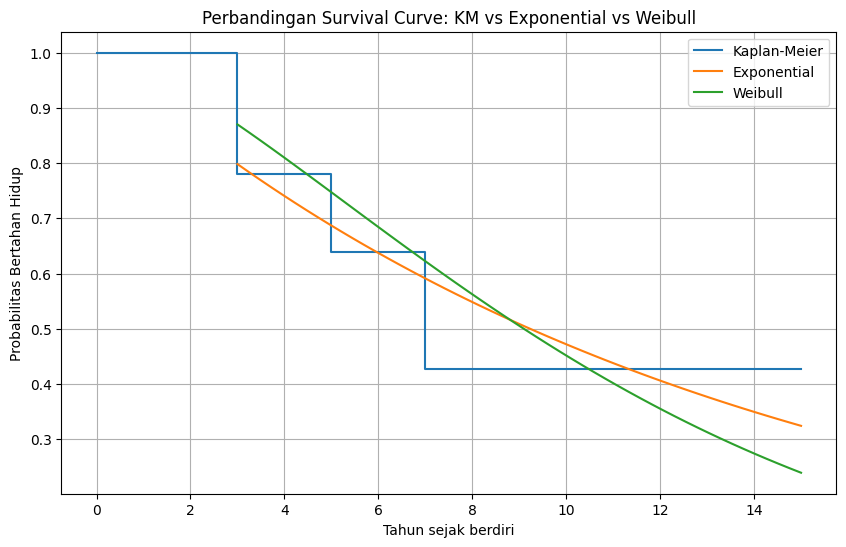

In [14]:
# Step 13: Fit semua model

from lifelines import KaplanMeierFitter, ExponentialFitter, WeibullFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
expf = ExponentialFitter()
weibf = WeibullFitter()

# Fit model
kmf.fit(df['duration'], event_observed=df['event_observed'], label="Kaplan-Meier")
expf.fit(df['duration'], event_observed=df['event_observed'], label="Exponential")
weibf.fit(df['duration'], event_observed=df['event_observed'], label="Weibull")

# Plot gabungan
plt.figure(figsize=(10, 6))

# Plot tiap survival curve
kmf.plot_survival_function(ci_show=False)
expf.plot_survival_function(ci_show=False)
weibf.plot_survival_function(ci_show=False)

plt.title("Perbandingan Survival Curve: KM vs Exponential vs Weibull")
plt.xlabel("Tahun sejak berdiri")
plt.ylabel("Probabilitas Bertahan Hidup")
plt.grid(True)
plt.legend()
plt.show()

Gambar ini membandingkan Kaplan-Meier, Exponential, dan Weibull dalam satu grafik; Weibull terlihat lebih fleksibel mengikuti tren empiris Kaplan-Meier dibanding Exponential yang terlalu halus.

Catatan:
- Eksplorasi awal tanpa asumsi -> Kaplan-Meier
- Ingin ekstrapolasi atau forecasting -> Weibull
- Skenario sederhana dengan hazard konstan -> Exponential

In [15]:
# Step 14: Mengevaluasi model survival secara kuantitatif menggunakan tiga metrik utama: Log-likelihood, Akaike Information Criterion (AIC), dan Bayesian Information Criterion (BIC).

from lifelines import KaplanMeierFitter, ExponentialFitter, WeibullFitter

kmf = KaplanMeierFitter()
expf = ExponentialFitter()
weibf = WeibullFitter()

# Fit model ke data
durations = df['duration']
events = df['event_observed']

kmf.fit(durations, event_observed=events)
expf.fit(durations, event_observed=events)
weibf.fit(durations, event_observed=events)

# Untuk model parametrik saja (non-parametrik seperti KMF tidak punya AIC/BIC)
models = {
    'Exponential': expf,
    'Weibull': weibf
}

for name, model in models.items():
    print(f"Model: {name}")
    print(f"  Log-likelihood: {model.log_likelihood_:.2f}")
    print(f"  AIC: {model.AIC_:.2f}")
    print(f"  BIC: {model.BIC_:.2f}\n")

Model: Exponential
  Log-likelihood: -100.50
  AIC: 203.00
  BIC: 204.92

Model: Weibull
  Log-likelihood: -98.25
  AIC: 200.49
  BIC: 204.32



Log-likelihood Weibull lebih tinggi → model lebih baik dalam menjelaskan data aktual.

AIC dan BIC Weibull lebih rendah → artinya, model ini lebih efisien dan tidak terlalu kompleks.

Ini menunjukkan bahwa hazard rate (tingkat risiko bangkrut/pivot) tidak konstan dari waktu ke waktu, tapi bisa berubah (naik atau turun), yang memang ditangkap dengan baik oleh distribusi Weibull.
    
Semakin tinggi log-likelihood, semakin baik fit-nya. Semakin rendah AIC dan BIC, semakin baik model (lebih parsimonious). Jika Weibull memiliki AIC dan BIC lebih rendah daripada Exponential, maka dia lebih cocok digunakan.